# 1. Initial Data Exploration

## 1.1 Imports and Loads

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from textblob import TextBlob
import ast
from collections import Counter
from datetime import datetime
from itertools import chain
%matplotlib inline
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saidgurbuz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saidgurbuz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saidgurbuz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
# set path to data
path = "../data/"

### Load Plot Summaries

In [8]:
# load plot summaries
plot_summaries_file = f"{path}plot_summaries.txt"

# the file is tab-separated with no header; columns are: wiki_movie_id, plot_summary
df_plots = pd.read_csv(
    plot_summaries_file, sep="\t", header=None, names=["wiki_movie_id", "plot_summary"]
)

### Load Movie Metadata

In [9]:
# load movie metadata
movie_metadata_file = f"{path}movie.metadata.tsv"

df_movies = pd.read_csv(movie_metadata_file, sep="\t", header=None)

# assign column names
df_movies.columns = [
    "wiki_movie_id",
    "freebase_movie_id",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

### Load Character Metadata

In [10]:
# load character metadata
character_metadata_file = f"{path}character.metadata.tsv"

df_characters = pd.read_csv(character_metadata_file, sep="\t", header=None)

# assign column names
df_characters.columns = [
    "wiki_movie_id",
    "freebase_movie_id",
    "movie_release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_release",
    "freebase_character_actor_map_id",
    "freebase_character_id",
    "freebase_actor_id",
]

In [11]:
df_characters.head()

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## 1.2 Data Preprocessing

In [12]:
# convert appropriate columns to numeric data types
df_movies["movie_box_office_revenue"] = pd.to_numeric(
    df_movies["movie_box_office_revenue"], errors="coerce"
)
df_movies["movie_runtime"] = pd.to_numeric(df_movies["movie_runtime"], errors="coerce")

In [13]:
# convert release date to datetime
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT


df_movies["movie_release_date"] = df_movies["movie_release_date"].apply(parse_date)
df_characters["movie_release_date"] = df_characters["movie_release_date"].apply(
    parse_date
)
df_characters["actor_dob"] = df_characters["actor_dob"].apply(parse_date)

### Process JSON-like Fields

In [14]:
def parse_dict(field):
    """Convert dictionary to a tuple (key, value) pairs"""
    try:
        return [x for x in ast.literal_eval(field).items()]
    except:
        return []


df_movies["movie_languages"] = df_movies["movie_languages"].apply(parse_dict)
df_movies["movie_countries"] = df_movies["movie_countries"].apply(parse_dict)
df_movies["movie_genres"] = df_movies["movie_genres"].apply(parse_dict)

### Handle Missing Values

In [15]:
# check for missing values and percentages
print("Movies Data Missing Values:")
print(
    pd.concat(
        [
            df_movies.isnull().sum(),
            (df_movies.isnull().sum() / len(df_movies) * 100).round(2).astype(str)
            + "%",
        ],
        axis=1,
        keys=["Missing Count", "Missing %"],
    )
)

print("\nCharacters Data Missing Values:")
print(
    pd.concat(
        [
            df_characters.isnull().sum(),
            (df_characters.isnull().sum() / len(df_characters) * 100)
            .round(2)
            .astype(str)
            + "%",
        ],
        axis=1,
        keys=["Missing Count", "Missing %"],
    )
)

print("\nPlots Data Missing Values:")
print(
    pd.concat(
        [
            df_plots.isnull().sum(),
            (df_plots.isnull().sum() / len(df_plots) * 100).round(2).astype(str) + "%",
        ],
        axis=1,
        keys=["Missing Count", "Missing %"],
    )
)

Movies Data Missing Values:
                          Missing Count Missing %
wiki_movie_id                         0      0.0%
freebase_movie_id                     0      0.0%
movie_name                            0      0.0%
movie_release_date                 6903     8.44%
movie_box_office_revenue          73340    89.72%
movie_runtime                     20450    25.02%
movie_languages                       0      0.0%
movie_countries                       0      0.0%
movie_genres                          0      0.0%

Characters Data Missing Values:
                                 Missing Count Missing %
wiki_movie_id                                0      0.0%
freebase_movie_id                            0      0.0%
movie_release_date                       10010     2.22%
character_name                          257875    57.22%
actor_dob                               106168    23.56%
actor_gender                             45609    10.12%
actor_height                            

## 1.3 Exploratory Data Analysis (EDA)

### Movies Data Analysis

#### Number of Movies

In [16]:
print(f"Total number of movies in metadata: {len(df_movies)}")
print(f"Total number of movies with plot summaries: {len(df_plots)}")

Total number of movies in metadata: 81741
Total number of movies with plot summaries: 42303


#### Merge Movies and Plots Data

In [17]:
# merge movies and plots on wiki_movie_id
df_movies_plots = pd.merge(df_movies, df_plots, on="wiki_movie_id", how="inner")
df_movies_plots.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/01jfsb, Thriller), (/m/06n90, Science Fic...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"[(/m/02h40lc, English Language)]","[(/m/07ssc, United Kingdom)]","[(/m/01jfsb, Thriller), (/m/0glj9q, Erotic thr...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"[(/m/04306rv, German Language)]","[(/m/0345h, Germany)]","[(/m/07s9rl0, Drama)]","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"[(/m/02h40lc, English Language)]","[(/m/0hzlz, South Africa)]","[(/m/0hqxf, Family Film), (/m/01hmnh, Fantasy)...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/06cvj, Romantic comedy), (/m/0hj3n0w, Ens...","Adam, a San Francisco-based artist who works a..."


#### Distribution over Years

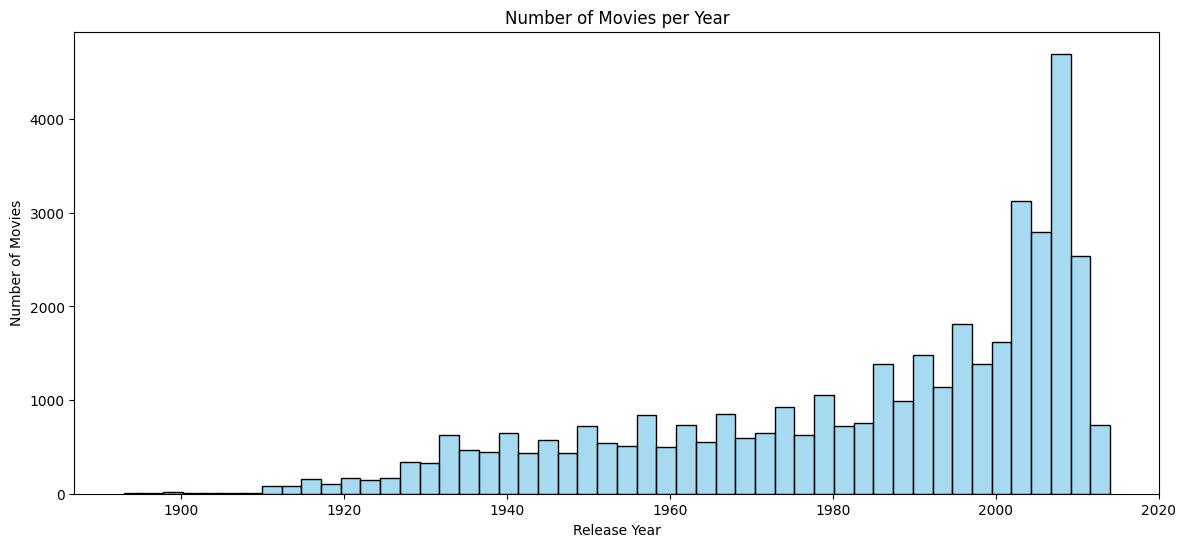

In [18]:
# extract year from release date
df_movies_plots["release_year"] = df_movies_plots["movie_release_date"].dt.year

# drop movies with missing release years
df_movies_plots_year = df_movies_plots.dropna(subset=["release_year"])

# plot histogram
plt.figure(figsize=(14, 6))
sns.histplot(df_movies_plots_year["release_year"], bins=50, kde=False, color="skyblue")
plt.title("Number of Movies per Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.show()

#### Top Genres

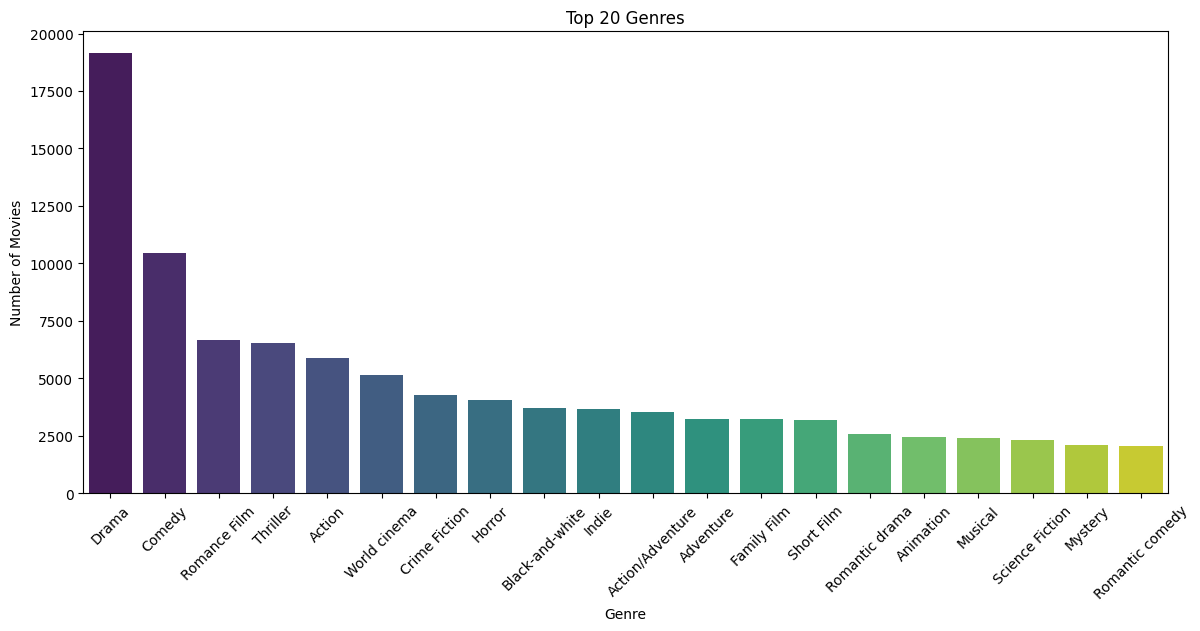

In [19]:
# extract genre names
df_movies_plots["genre_names"] = df_movies_plots["movie_genres"].apply(
    lambda x: [name for _, name in x]
)

# count genres
all_genres = list(chain.from_iterable(df_movies_plots["genre_names"]))

genre_counts = Counter(all_genres)

# top 20 genres
top_genres = genre_counts.most_common(20)

# plot
genres, counts = zip(*top_genres)
plt.figure(figsize=(14, 6))
sns.barplot(x=list(genres), y=list(counts), palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 20 Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()

#### Distribution of Genres over the Years

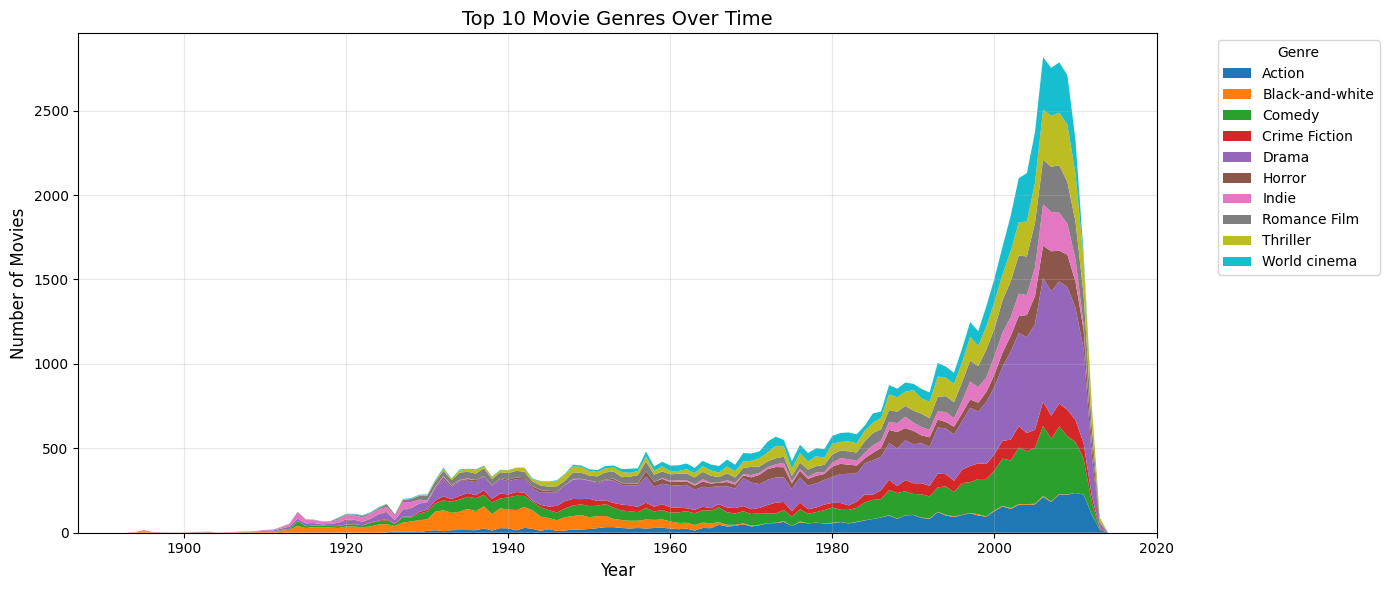

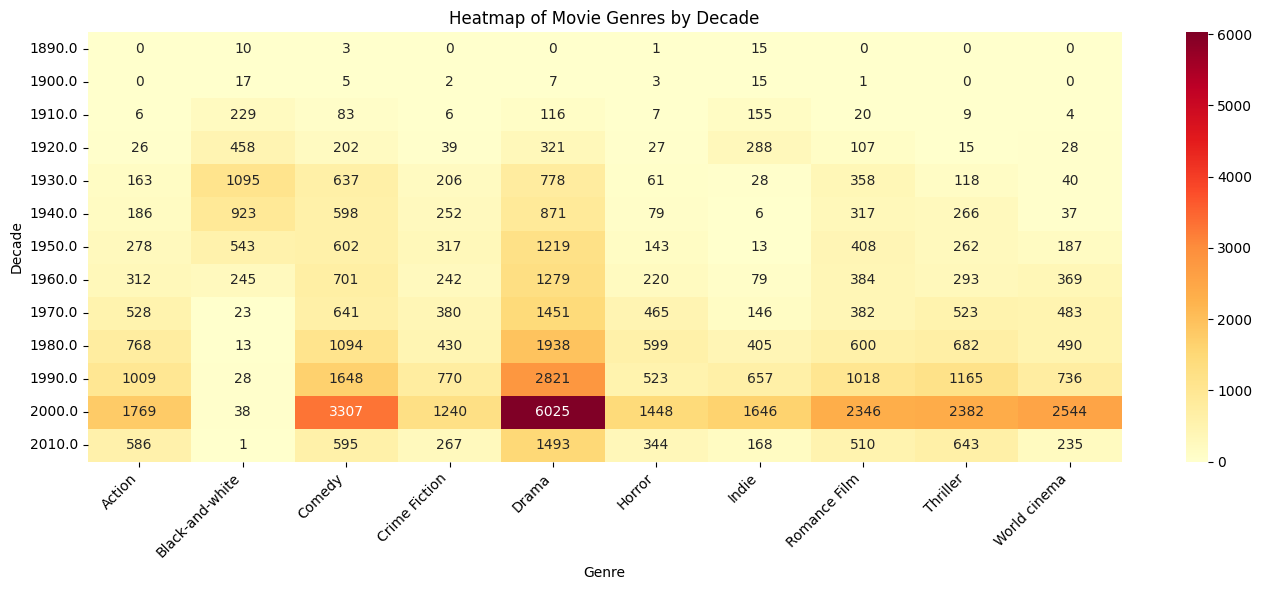

In [20]:
# create a dataframe with genres and years
genre_year_data = []
for _, row in df_movies_plots.iterrows():
    year = row["release_year"]
    for genre in row["genre_names"]:
        genre_year_data.append({"year": year, "genre": genre})

df_genre_years = pd.DataFrame(genre_year_data)

# get top 10 most common genres for cleaner visualization
top_10_genres = [genre for genre, count in genre_counts.most_common(10)]
df_genre_years_filtered = df_genre_years[df_genre_years["genre"].isin(top_10_genres)]

# create pivot table for stacked area plot
genre_by_year = pd.crosstab(
    df_genre_years_filtered["year"], df_genre_years_filtered["genre"]
)

# create stacked area plot
plt.figure(figsize=(14, 6))
plt.stackplot(
    genre_by_year.index,
    [genre_by_year[col] for col in genre_by_year.columns],
    labels=genre_by_year.columns,
)
plt.title("Top 10 Movie Genres Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# additional view: heatmap
df_genre_years_filtered["decade"] = (df_genre_years_filtered["year"] // 10) * 10
genre_by_decade = pd.crosstab(
    df_genre_years_filtered["decade"], df_genre_years_filtered["genre"]
)

plt.figure(figsize=(14, 6))
sns.heatmap(genre_by_decade, cmap="YlOrRd", annot=True, fmt="g")
plt.title("Heatmap of Movie Genres by Decade")
plt.xlabel("Genre")
plt.ylabel("Decade")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Distribution of Box Office Revenues

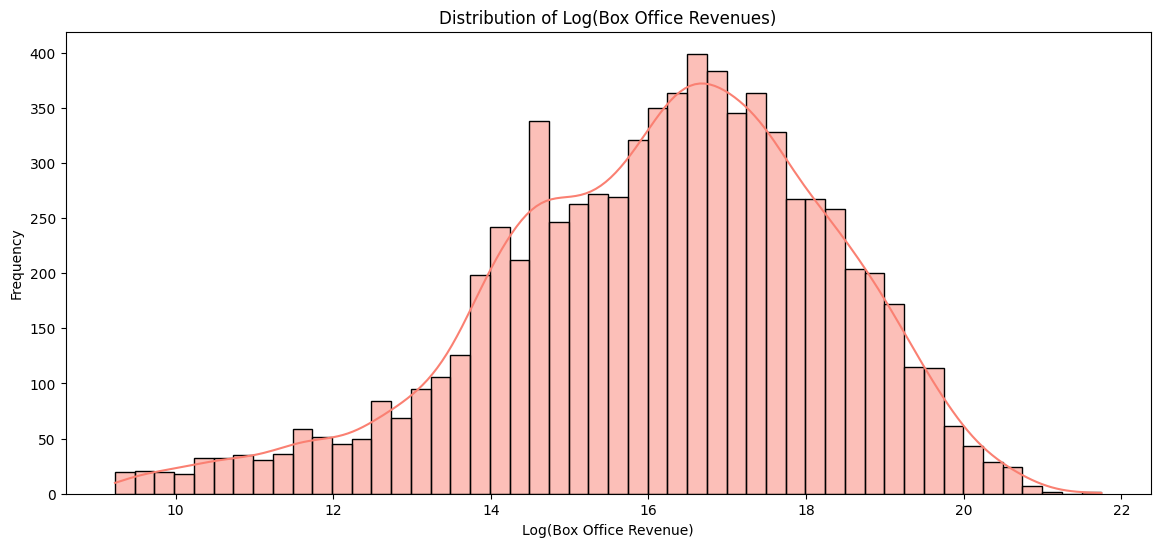

In [21]:
# drop missing revenues
df_revenue = df_movies_plots.dropna(subset=["movie_box_office_revenue"])

# apply log scale
df_revenue["log_revenue"] = np.log1p(df_revenue["movie_box_office_revenue"])

plt.figure(figsize=(14, 6))
sns.histplot(df_revenue["log_revenue"], bins=50, kde=True, color="salmon")
plt.title("Distribution of Log(Box Office Revenues)")
plt.xlabel("Log(Box Office Revenue)")
plt.ylabel("Frequency")
plt.show()

#### Distribution of Box Office Revenues over the Years

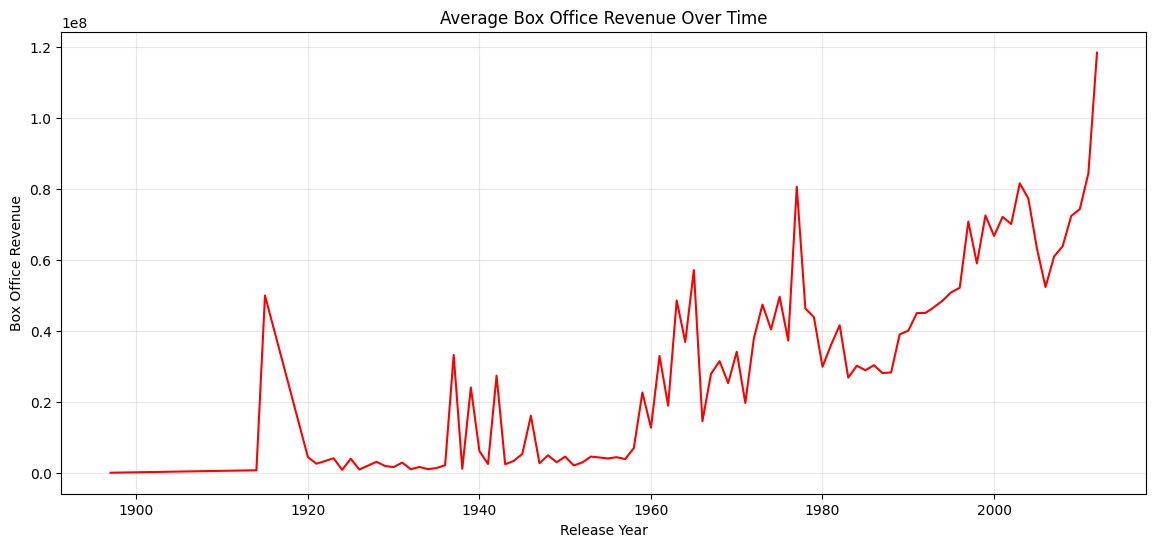

In [22]:
plt.figure(figsize=(14, 6))
yearly_avg = df_revenue.groupby("release_year")["movie_box_office_revenue"].mean()
sns.lineplot(x=yearly_avg.index, y=yearly_avg.values, color="red")
plt.title("Average Box Office Revenue Over Time")
plt.xlabel("Release Year")
plt.ylabel("Box Office Revenue")
plt.grid(True, alpha=0.3)
plt.show()

#### Average Box Office Revenue per Genre over the Years

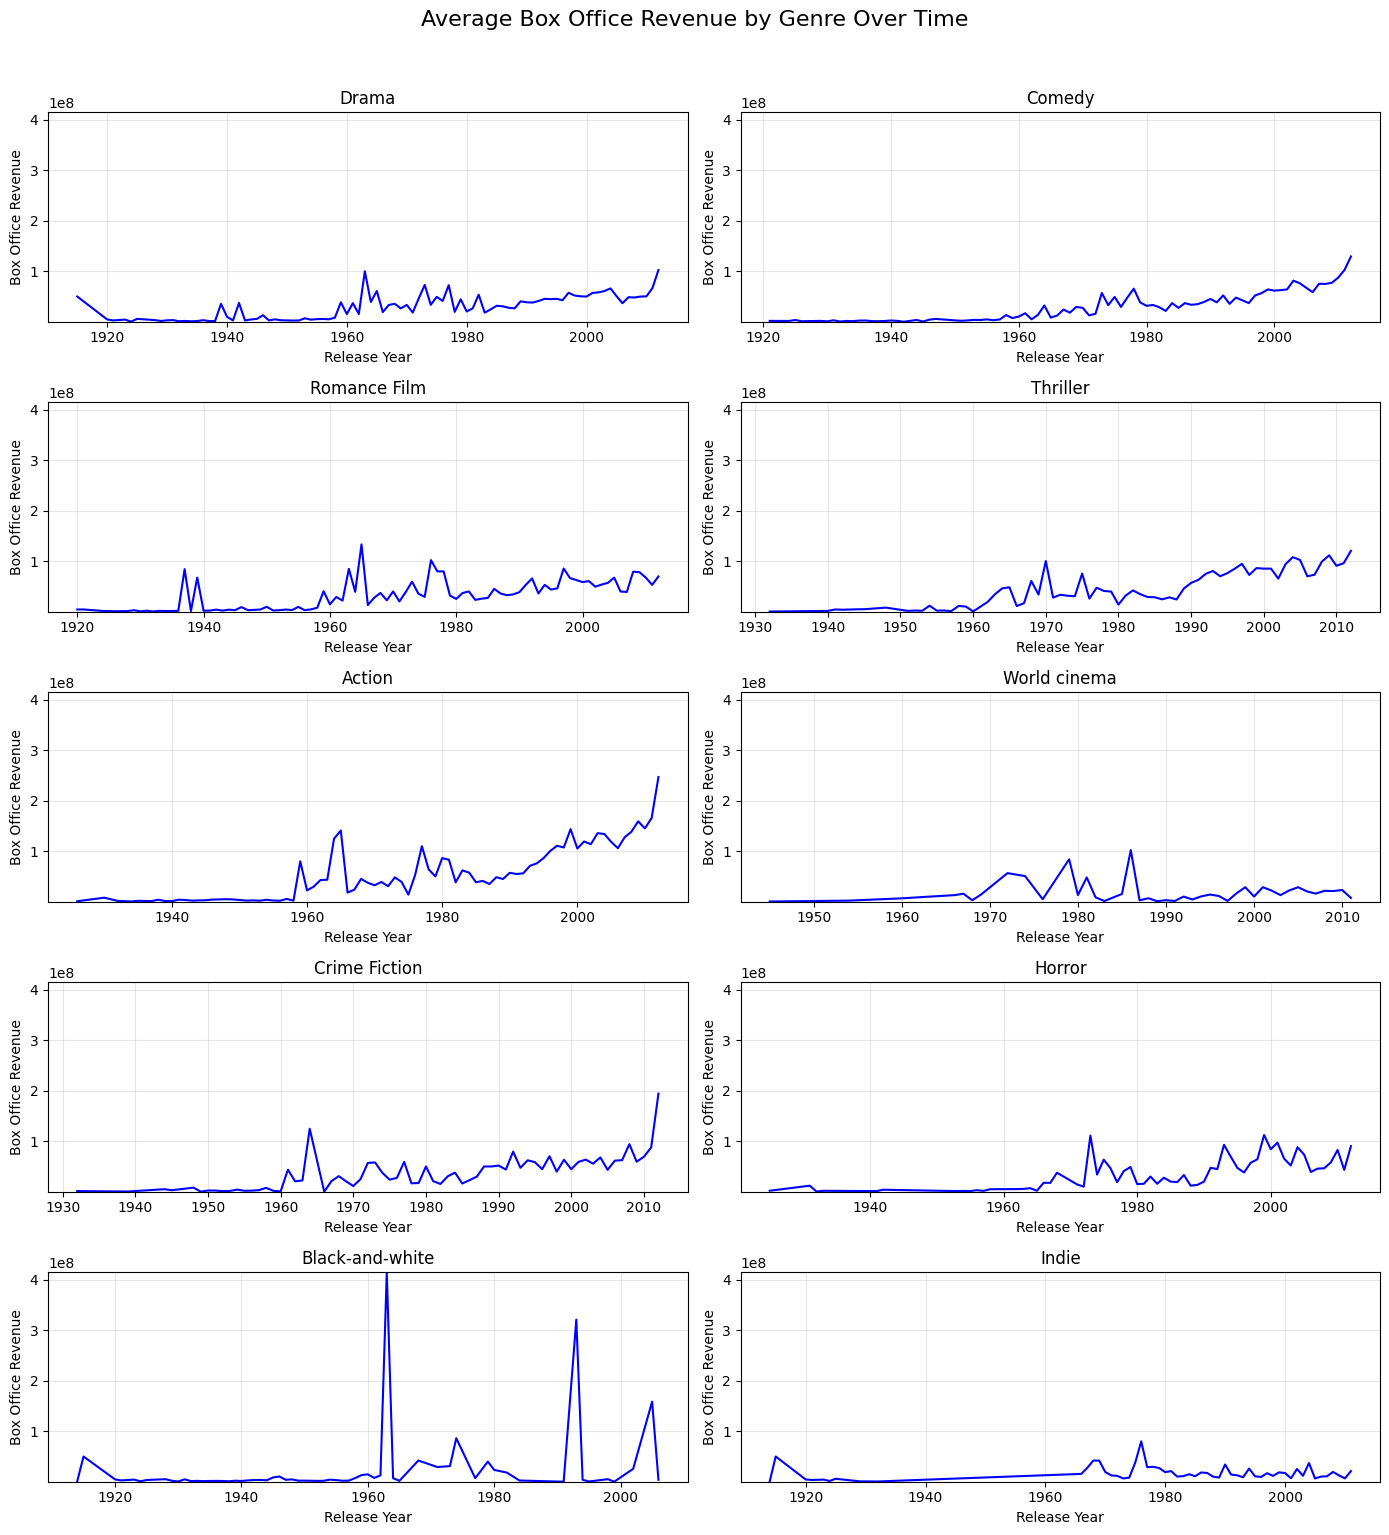

In [23]:
# get top 10 genres
genre_counts = df_movies_plots["genre_names"].apply(pd.Series).stack().value_counts()
top_10_genres = dict(
    sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]
)

fig, axes = plt.subplots(5, 2, figsize=(14, 15))
axes = axes.flatten()

# find global min and max for consistent y-axis
y_min = float("inf")
y_max = float("-inf")
for genre in top_10_genres:
    genre_movies = df_revenue[
        df_revenue["movie_genres"].apply(
            lambda x: any(genre == g[1] for g in x) if isinstance(x, list) else False
        )
    ]
    yearly_avg = genre_movies.groupby("release_year")["movie_box_office_revenue"].mean()
    y_min = min(y_min, yearly_avg.min())
    y_max = max(y_max, yearly_avg.max())

# plot each genre in its own subplot
for idx, (genre, ax) in enumerate(zip(top_10_genres, axes)):
    genre_movies = df_revenue[
        df_revenue["movie_genres"].apply(
            lambda x: any(genre == g[1] for g in x) if isinstance(x, list) else False
        )
    ]
    yearly_avg = genre_movies.groupby("release_year")["movie_box_office_revenue"].mean()
    sns.lineplot(x=yearly_avg.index, y=yearly_avg.values, ax=ax, color="blue")
    ax.set_title(f"{genre}")
    ax.set_xlabel("Release Year")
    ax.set_ylabel("Box Office Revenue")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y_min, y_max)

plt.suptitle("Average Box Office Revenue by Genre Over Time", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#### Distribution of Runtimes

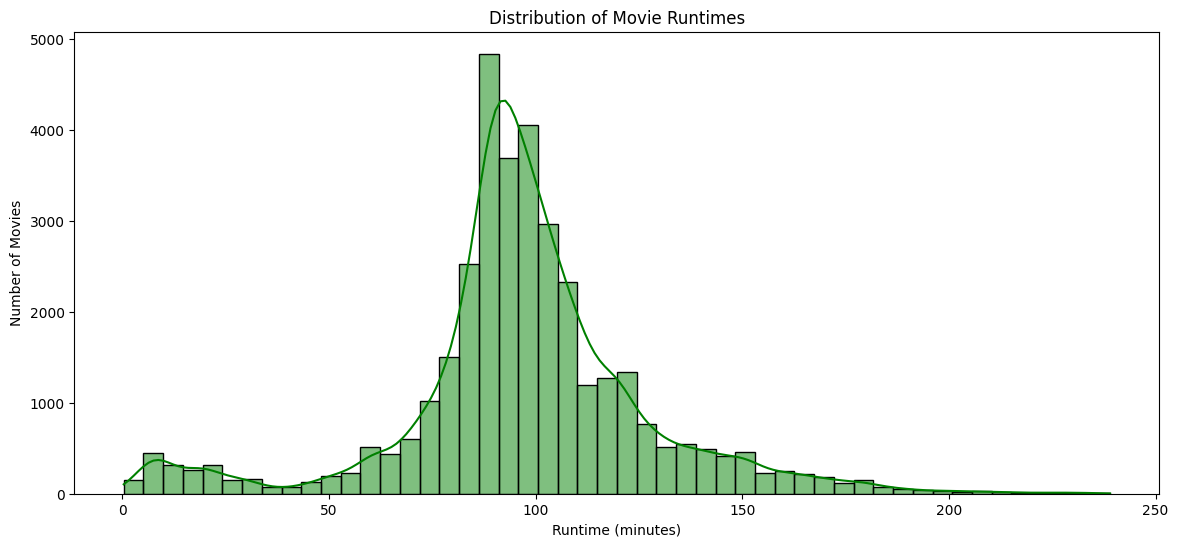

In [24]:
# drop missing runtimes
df_runtime = df_movies_plots.dropna(subset=["movie_runtime"])

# assume there exists typo and remove movies with runtime > 240 minutes
df_runtime = df_runtime[df_runtime["movie_runtime"] < 240]

plt.figure(figsize=(14, 6))
sns.histplot(df_runtime["movie_runtime"], bins=50, kde=True, color="green")
plt.title("Distribution of Movie Runtimes")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Number of Movies")
plt.show()

#### Movie Runtime Changes Over Time

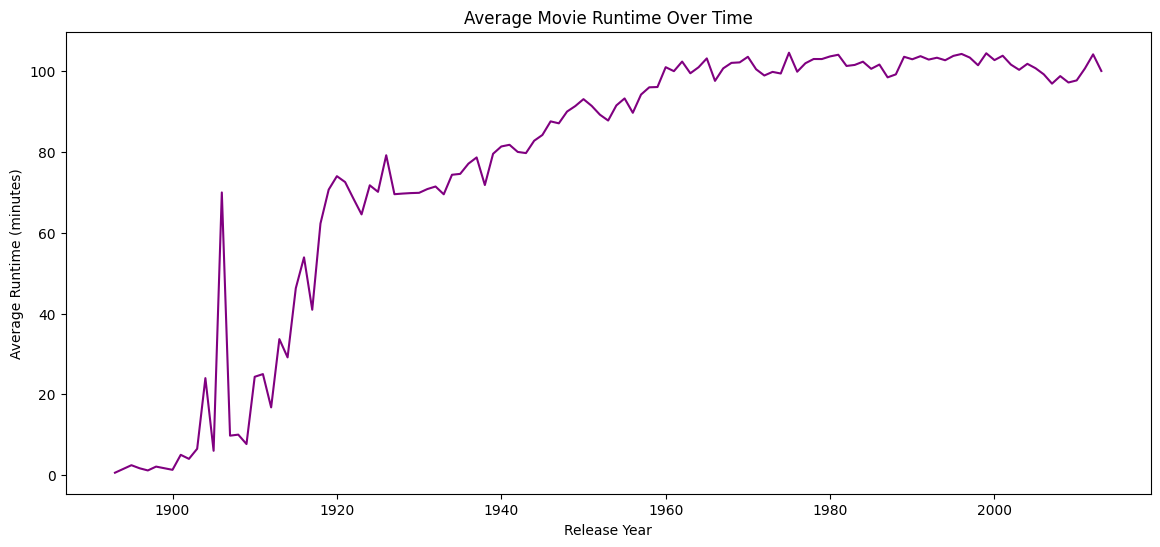

In [25]:
# group by year and calculate average runtime
runtime_year = df_runtime.groupby("release_year")["movie_runtime"].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x=runtime_year.index, y=runtime_year.values, color="purple")
plt.title("Average Movie Runtime Over Time")
plt.xlabel("Release Year")
plt.ylabel("Average Runtime (minutes)")
plt.show()

#### Languages and Countries

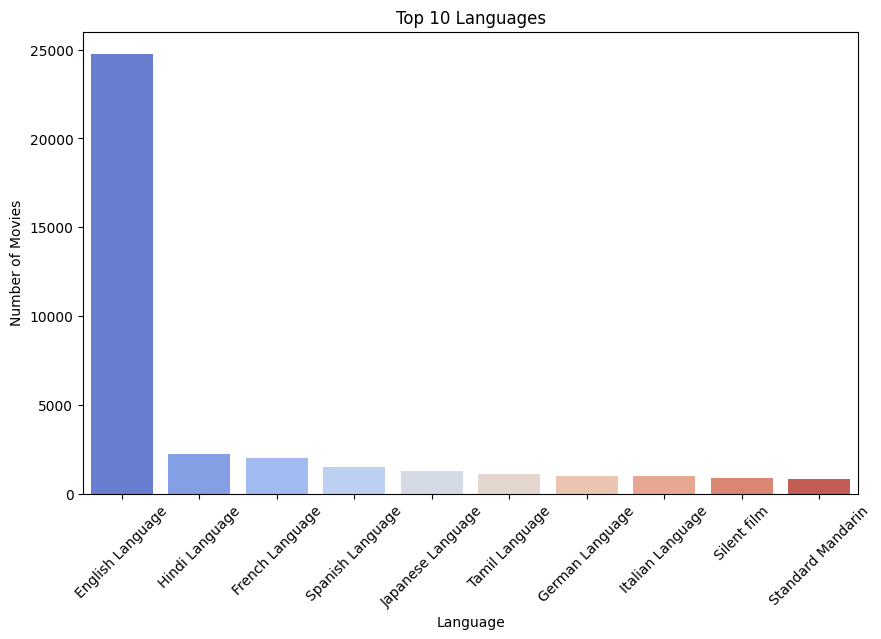

In [26]:
# extract language names
df_movies_plots["language_names"] = df_movies_plots["movie_languages"].apply(
    lambda x: [name for _, name in x]
)

all_languages = list(chain.from_iterable(df_movies_plots["language_names"]))

language_counts = Counter(all_languages)

# top 10 languages
top_languages = language_counts.most_common(10)

languages, counts = zip(*top_languages)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(languages), y=list(counts), palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Languages")
plt.xlabel("Language")
plt.ylabel("Number of Movies")
plt.show()

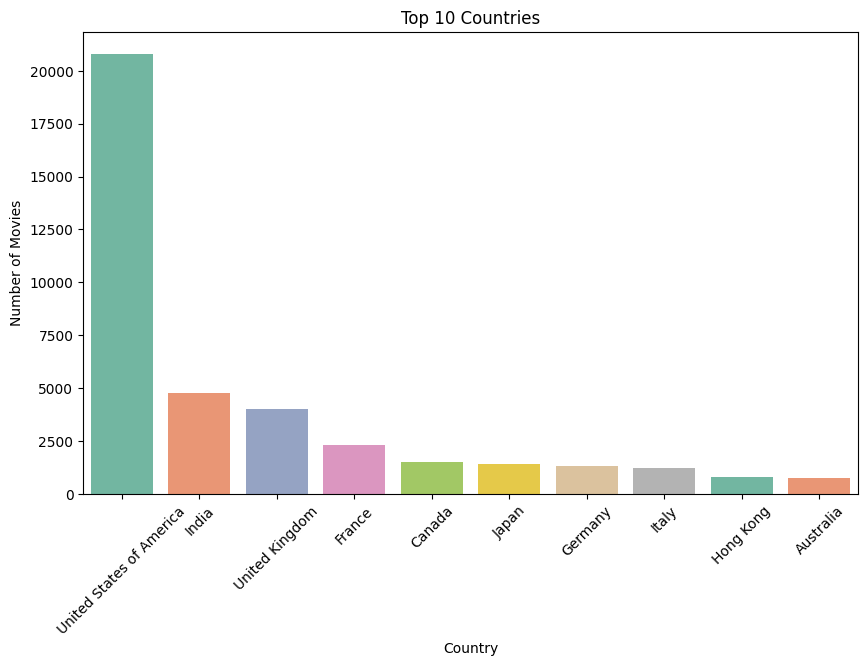

In [27]:
# extract country names
df_movies_plots["country_names"] = df_movies_plots["movie_countries"].apply(
    lambda x: [name for _, name in x]
)

all_countries = list(chain.from_iterable(df_movies_plots["country_names"]))

country_counts = Counter(all_countries)

# top 10 countries
top_countries = country_counts.most_common(10)

countries, counts = zip(*top_countries)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(countries), y=list(counts), palette="Set2")
plt.xticks(rotation=45)
plt.title("Top 10 Countries")
plt.xlabel("Country")
plt.ylabel("Number of Movies")
plt.show()

### Characters Data Analysis

#### Number of Characters

In [28]:
print(f"Total number of characters: {len(df_characters)}")

Total number of characters: 450669


#### Gender Distribution

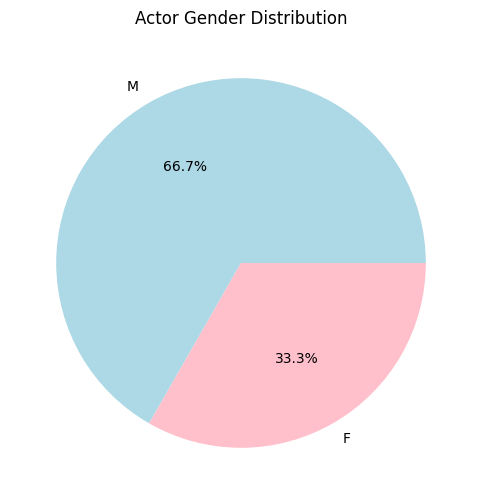

In [29]:
# value counts of actor_gender
gender_counts = df_characters["actor_gender"].value_counts()

plt.figure(figsize=(6, 6))
gender_counts.plot(
    kind="pie", autopct="%1.1f%%", colors=["lightblue", "pink", "lightgreen"]
)
plt.title("Actor Gender Distribution")
plt.ylabel("")
plt.show()

#### Age Distribution

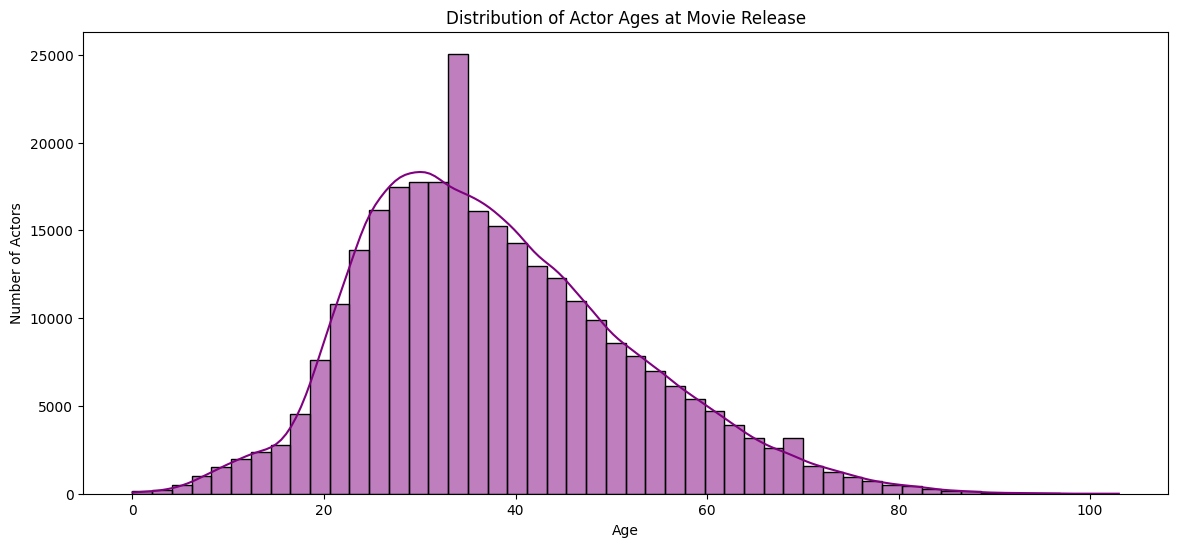

In [30]:
# drop missing ages
df_ages = df_characters.dropna(subset=["actor_age_at_release"])

# drop ages < 0
df_ages = df_ages[df_ages["actor_age_at_release"] >= 0]

plt.figure(figsize=(14, 6))
sns.histplot(df_ages["actor_age_at_release"], bins=50, kde=True, color="purple")
plt.title("Distribution of Actor Ages at Movie Release")
plt.xlabel("Age")
plt.ylabel("Number of Actors")
plt.show()

#### Actor Height

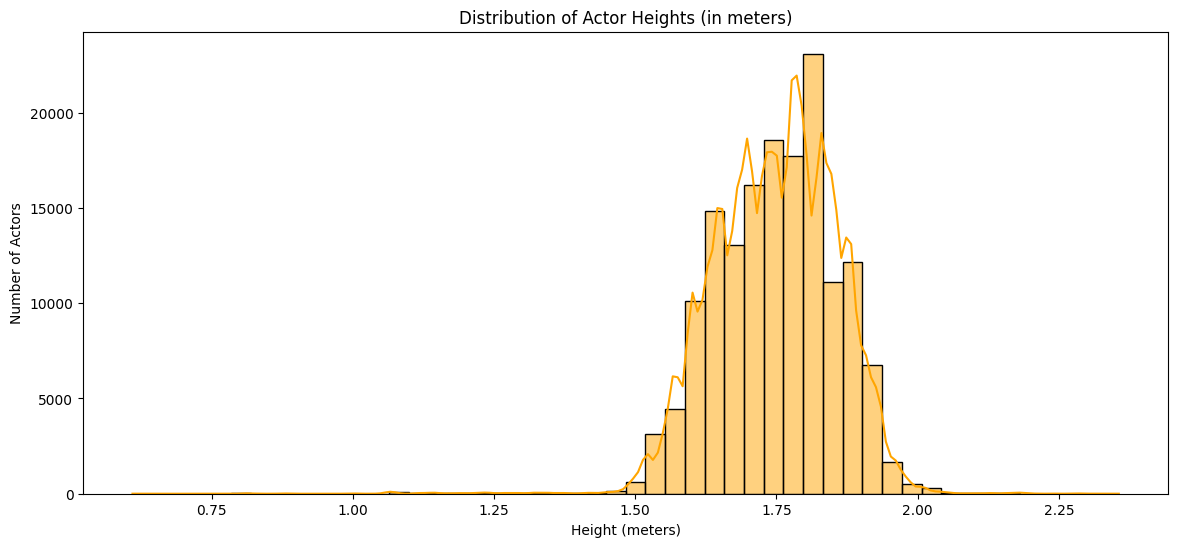

In [31]:
# convert actor_height to numeric
df_characters["actor_height"] = pd.to_numeric(
    df_characters["actor_height"], errors="coerce"
)

# drop missing heights
df_heights = df_characters.dropna(subset=["actor_height"])

# drop heights < 0 and > 3 meters
df_heights = df_heights[
    (df_heights["actor_height"] >= 0) & (df_heights["actor_height"] <= 3)
]


plt.figure(figsize=(14, 6))
sns.histplot(df_heights["actor_height"], bins=50, kde=True, color="orange")
plt.title("Distribution of Actor Heights (in meters)")
plt.xlabel("Height (meters)")
plt.ylabel("Number of Actors")
plt.show()

### Text Analysis of Plot Summaries

#### Word Frequency

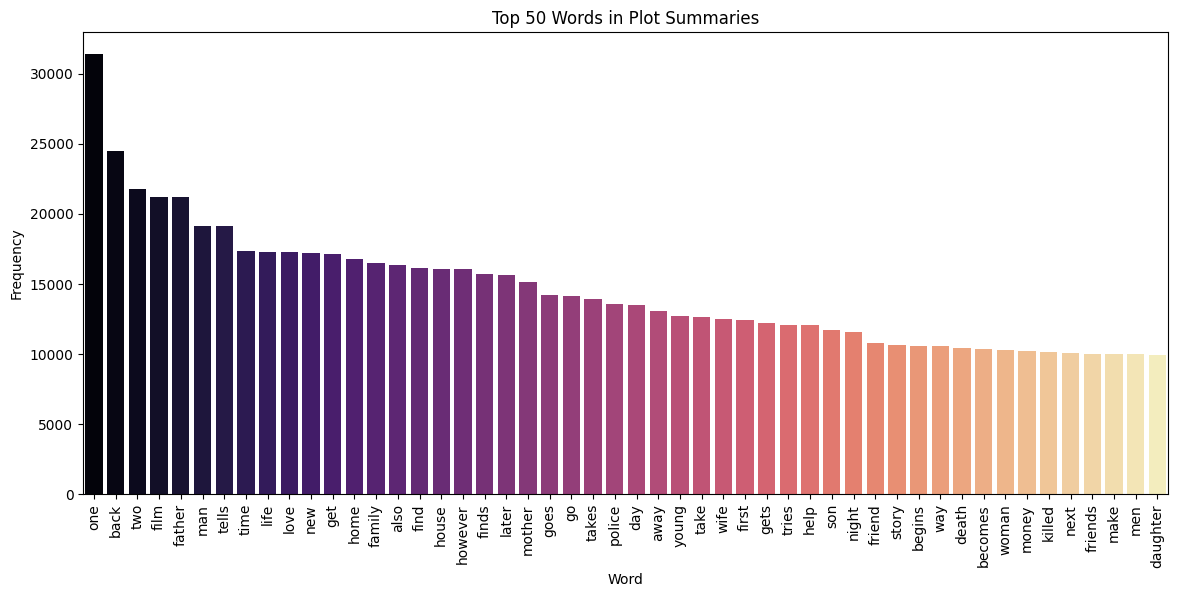

In [32]:
stop_words = set(stopwords.words("english"))
# combine all plot summaries into one text
all_plots_text = " ".join(df_plots["plot_summary"])
# tokenize
words = word_tokenize(all_plots_text.lower())
# remove stopwords and punctuation
words = [word for word in words if word.isalpha() and word not in stop_words]
# get word frequencies
word_freq = Counter(words)
# top 50 words
top_words = word_freq.most_common(50)
# plot
words_list, counts = zip(*top_words)
plt.figure(figsize=(14, 6))
sns.barplot(x=list(words_list), y=list(counts), palette="magma")
plt.xticks(rotation=90)
plt.title("Top 50 Words in Plot Summaries")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

#### Word Cloud per Genre

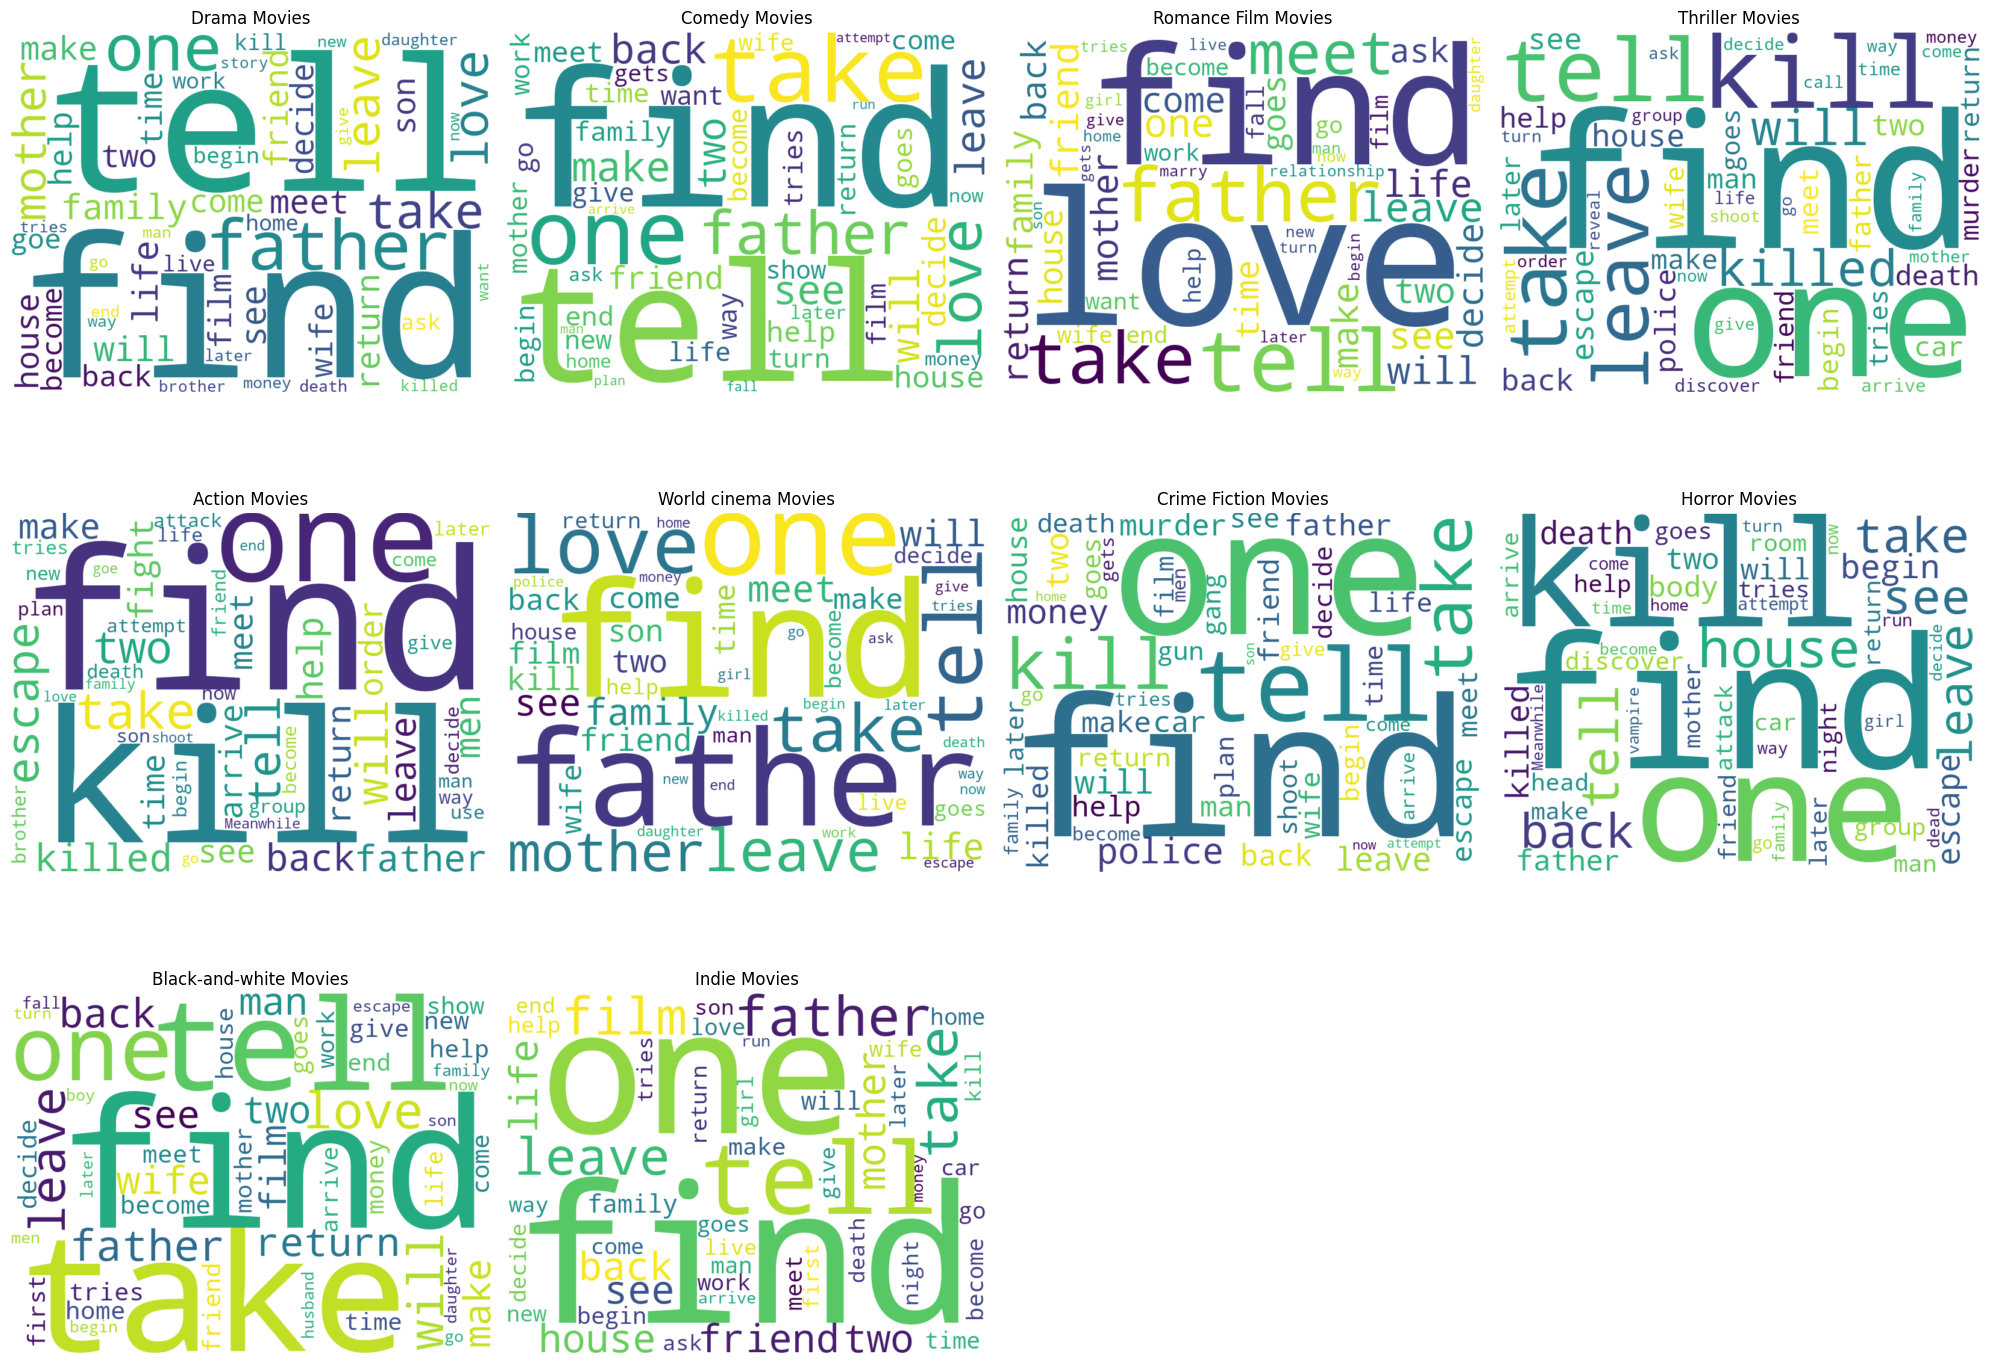

In [33]:
# get top 10 genres
genre_counts = df_movies_plots["genre_names"].apply(pd.Series).stack().value_counts()
top_10_genres = dict(
    sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]
)

# create subplot for each genre
plt.figure(figsize=(20, 15))
for idx, (genre, _) in enumerate(top_10_genres.items(), 1):
    # filter plots for current genre
    genre_plots = df_movies_plots[
        df_movies_plots["genre_names"].apply(lambda x: genre in str(x))
    ]
    # combine plot summaries
    text = " ".join(genre_plots["plot_summary"])
    # create and generate a word cloud image
    plt.subplot(3, 4, idx)
    wordcloud = WordCloud(
        width=800, height=600, background_color="white", max_words=50
    ).generate(text)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{genre} Movies")

plt.tight_layout()
plt.show()

#### Sentiment Analysis

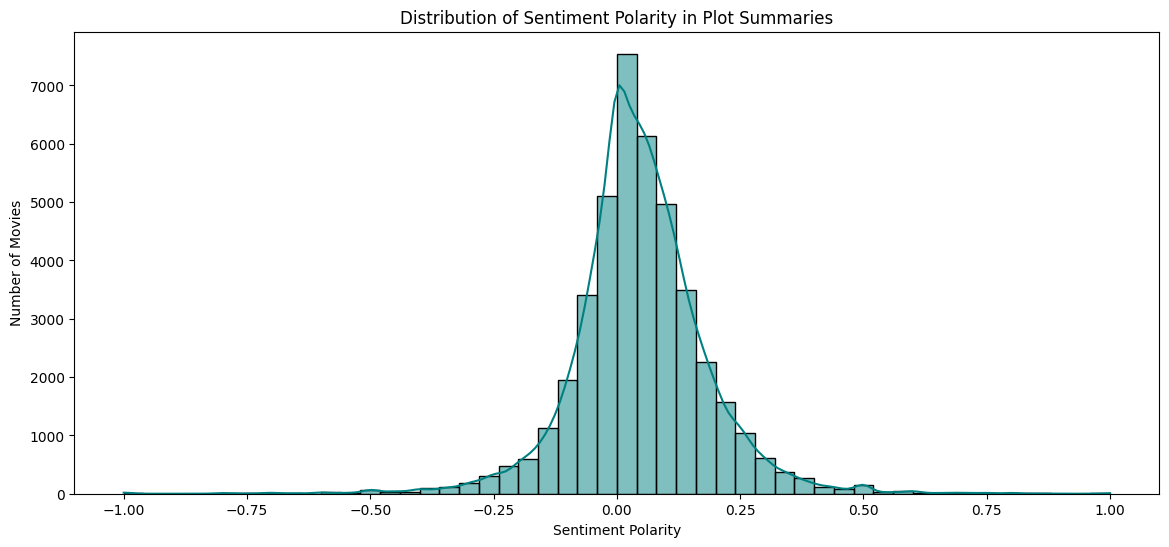

In [34]:
# only a basic sentiment analysis is performed here for now
# get sentiment polarity for each plot summary (actually this is not that meaningful for plot summaries, could be much more useful for reviews)
df_plots["sentiment_polarity"] = df_plots["plot_summary"].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

plt.figure(figsize=(14, 6))
sns.histplot(df_plots["sentiment_polarity"], bins=50, kde=True, color="teal")
plt.title("Distribution of Sentiment Polarity in Plot Summaries")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Movies")
plt.show()

#### Topic Modeling

In [35]:
# use CountVectorizer for LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
dtm = vectorizer.fit_transform(df_plots["plot_summary"])

# perform LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)


# show the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx+1}:")
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]]
            )
        )


tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 10)


Topic 1:
father love family police gets son brother mother money house

Topic 2:
ship earth world time group escape crew island new human

Topic 3:
dr town house killed police body kill man dead death

Topic 4:
father love son life village johnny man story fight master

Topic 5:
film life school new young love story family time old

Topic 6:
tom jerry king father prince mary away castle tells queen

Topic 7:
tells house home night goes car finds later mother day

Topic 8:
war men killed army police escape american officer soldiers agent

Topic 9:
bugs jack dog cat tries away gets sam just time

Topic 10:
wife father life family husband love man daughter home mother


### Relationships

#### Correlation between Box Office Revenue and Other Variables

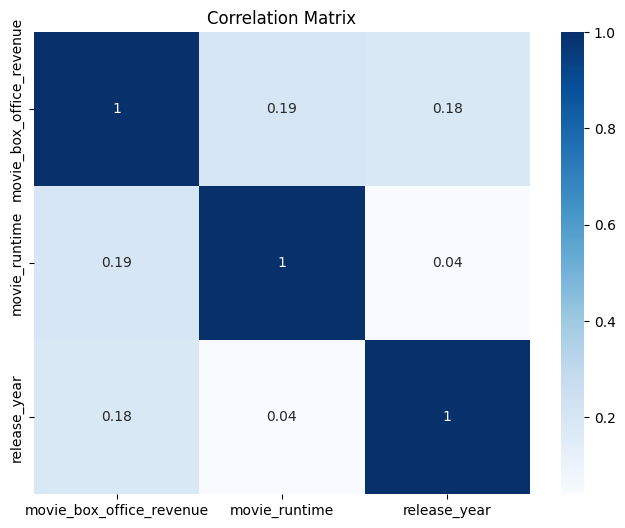

In [36]:
# select relevant numeric columns
df_corr = df_movies_plots[
    ["movie_box_office_revenue", "movie_runtime", "release_year"]
].dropna()

# calculate correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

#### Regression Analysis

In [37]:
import statsmodels.formula.api as smf

# fit a linear regression model
model = smf.ols(
    formula="movie_box_office_revenue ~ movie_runtime", data=df_movies_plots
)
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.038
Model:                                  OLS   Adj. R-squared:                  0.038
Method:                       Least Squares   F-statistic:                     294.3
Date:                      Thu, 07 Nov 2024   Prob (F-statistic):           9.71e-65
Time:                              02:16:46   Log-Likelihood:            -1.5009e+05
No. Observations:                      7513   AIC:                         3.002e+05
Df Residuals:                          7511   BIC:                         3.002e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

#### Relationship between Genre and Revenue

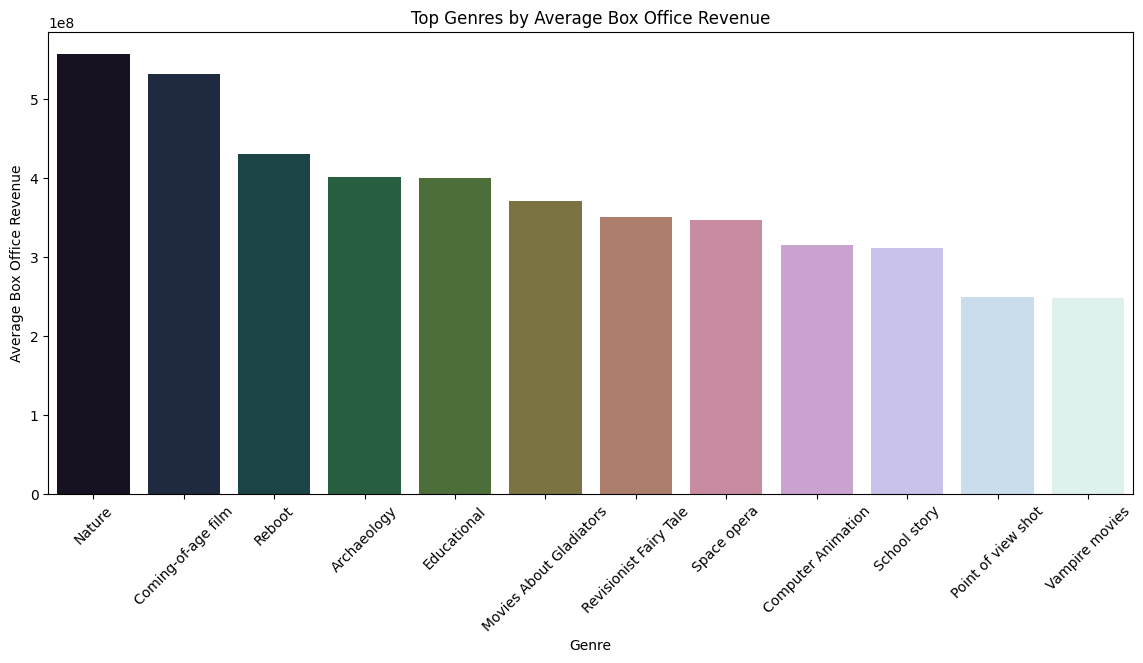

In [38]:
# explode genres
df_genres = df_movies_plots.explode("genre_names")

# group by genre and calculate average revenue
genre_revenue = (
    df_genres.groupby("genre_names")["movie_box_office_revenue"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

# top 10 genres by average revenue
top_genre_revenue = genre_revenue.head(12)

plt.figure(figsize=(14, 6))
sns.barplot(x=top_genre_revenue.index, y=top_genre_revenue.values, palette="cubehelix")
plt.xticks(rotation=45)
plt.title("Top Genres by Average Box Office Revenue")
plt.xlabel("Genre")
plt.ylabel("Average Box Office Revenue")
plt.show()

#### Gender Representation Over Time

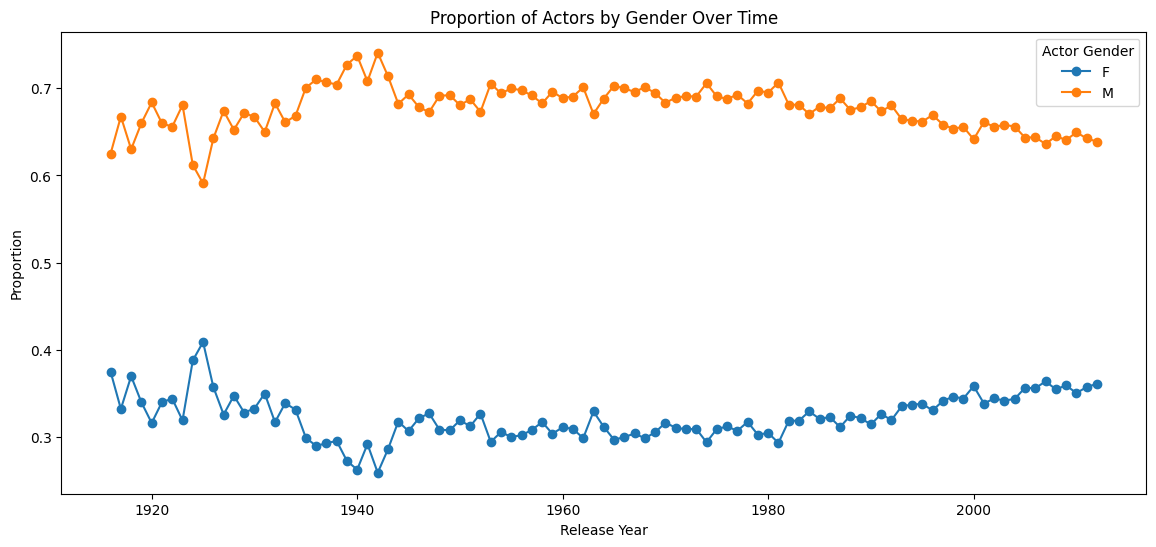

In [39]:
# merge characters with movies on wiki_movie_id
df_characters_movies = pd.merge(
    df_characters,
    df_movies[["wiki_movie_id"]],
    on="wiki_movie_id",
    how="inner",
)


# extract release year
df_characters_movies["release_year"] = pd.to_datetime(
    df_characters_movies["movie_release_date"]
).dt.year

# group by year and gender
gender_year = (
    df_characters_movies.groupby(["release_year", "actor_gender"]).size().unstack()
)

# calculate proportion
gender_year_prop = gender_year.div(gender_year.sum(axis=1), axis=0)

# drop missing values
gender_year_prop = gender_year_prop.dropna()

# drop first 20 and last 4 release years as they have very few movies
gender_year_prop = gender_year_prop.iloc[20:-4]

# plot proportion over time
gender_year_prop.plot(kind="line", figsize=(14, 6), marker="o")
plt.title("Proportion of Actors by Gender Over Time")
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.legend(title="Actor Gender")
plt.show()

In [40]:
gender_year.sort_values(by="release_year", ascending=True).head(10)

actor_gender,F,M
release_year,,
1888.0,2.0,2.0
1891.0,NaN,1.0
1893.0,NaN,2.0
1894.0,1.0,3.0
1895.0,NaN,1.0
1896.0,5.0,4.0
1897.0,2.0,1.0
1898.0,1.0,3.0
1899.0,4.0,2.0


## Merging TMDB and CMU Data

In [ ]:
# Download dataset from Kaggle

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

# print("Path to dataset files:", path)

In [ ]:
# how many not-nan movie_box_office_revenue values are there?
df_movies["movie_release_date"].dt.year

0        2001.0
1        2000.0
2        1988.0
3        1987.0
4        1983.0
          ...  
81736    2011.0
81737    2011.0
81738    1972.0
81739    1992.0
81740    2002.0
Name: movie_release_date, Length: 81741, dtype: float64

In [54]:
tmdb_metadata_file = "../TMDB/movies_metadata.csv"
df_tmdb = pd.read_csv(tmdb_metadata_file, low_memory=False)

# Extract release year from release_date
df_tmdb["release_year"] = pd.to_datetime(
    df_tmdb["release_date"], errors="coerce"
).dt.year

# Convert budget to numeric, coerce errors to NaN
df_tmdb["budget"] = pd.to_numeric(df_tmdb["budget"], errors="coerce")
df_tmdb["revenue"] = pd.to_numeric(df_tmdb["revenue"], errors="coerce")

# Ensure movie_release_date is in datetime format and extract year
df_movies["release_year"] = pd.to_datetime(
    df_movies["movie_release_date"], errors="coerce"
).dt.year

# Merge the TMDB dataset with the existing df_movies DataFrame
df_movies_merged = pd.merge(
    df_movies,
    df_tmdb[["title", "release_year", "revenue"]],
    left_on=["movie_name", "release_year"],
    right_on=["title", "release_year"],
    how="left",
)

# Check for missing values in the revenue column
print(
    "Missing values in revenue column after merge:",
    df_movies_merged["revenue"].isnull().sum(),
)

# Create a combined revenue column
df_movies_merged["combined_revenue"] = df_movies_merged["revenue"].combine_first(
    df_movies_merged["movie_box_office_revenue"]
)

# Display the first few rows of the enriched DataFrame
df_movies_merged.head()

Missing values in revenue column after merge: 60597


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,title,revenue,combined_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/01jfsb, Thriller), (/m/06n90, Science Fic...",2001.0,Ghosts of Mars,14010832.0,14010832.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/02n4kr, Mystery), (/m/03bxz7, Biographica...",2000.0,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"[(/m/05f_3, Norwegian Language)]","[(/m/05b4w, Norway)]","[(/m/0lsxr, Crime Fiction), (/m/07s9rl0, Drama)]",1988.0,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"[(/m/02h40lc, English Language)]","[(/m/07ssc, United Kingdom)]","[(/m/01jfsb, Thriller), (/m/0glj9q, Erotic thr...",1987.0,NaN,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"[(/m/04306rv, German Language)]","[(/m/0345h, Germany)]","[(/m/07s9rl0, Drama)]",1983.0,NaN,NaN,NaN


In [59]:
# print the rows only contains not nan values for both revenue and movie_box_office_revenue
df_movies_merged_not_nan = df_movies_merged.dropna(subset=["combined_revenue"])

# number of rows
print(
    "Number of rows with both revenue and movie_box_office_revenue values:",
    len(df_movies_merged_not_nan),
)

df_movies_merged_not_nan.head()

Number of rows with both revenue and movie_box_office_revenue values: 22913


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,title,revenue,combined_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/01jfsb, Thriller), (/m/06n90, Science Fic...",2001.0,Ghosts of Mars,14010832.0,14010832.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/04t36, Musical), (/m/01z4y, Comedy), (/m/...",1938.0,Alexander's Ragtime Band,4000000.0,4000000.0
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"[(/m/02h40lc, English Language)]","[(/m/07ssc, United Kingdom)]","[(/m/04xvh5, Costume drama), (/m/082gq, War fi...",1989.0,Henry V,0.0,0.0
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/0hj3myq, Children's/Family), (/m/04t36, M...",1964.0,Mary Poppins,102272727.0,102272727.0
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[(/m/02h40lc, English Language)]","[(/m/09c7w0, United States of America)]","[(/m/01jfsb, Thriller), (/m/06n90, Science Fic...",1999.0,NaN,NaN,21521.0
